In [362]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from scipy.ndimage import maximum_filter

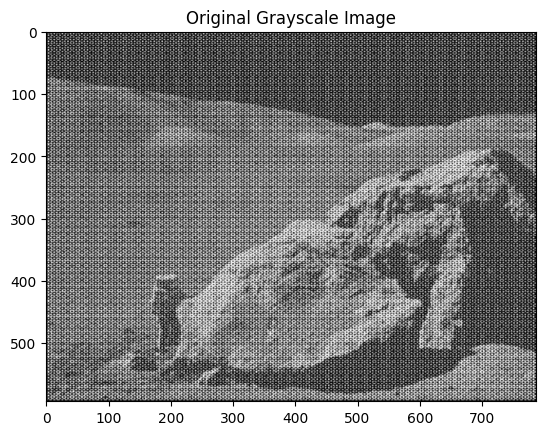

In [363]:
image = plt.imread("./example/periodic_noise.jpg")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap="gray")
plt.title("Original Grayscale Image")
plt.show()

In [364]:
image_gray = image_gray.astype(np.float32)
# Загрузка в GPU
d_image = cp.array(image_gray)
# Прямое преобразование Фурье
fft_image = cp.fft.fft2(d_image)
fft_image_shifted = cp.fft.fftshift(fft_image)
print(d_image.shape)

(594, 787)


In [365]:

magnitude_spectrum = cp.abs(fft_image_shifted)

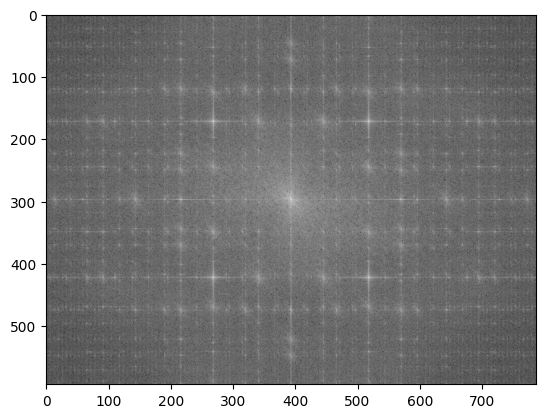

In [366]:
log_spectrum = 20*np.log(magnitude_spectrum + 1)
log_spectrum = log_spectrum.get()
plt.imshow(log_spectrum, cmap = 'gray')

In [367]:
threshold = np.max(log_spectrum) * 0.55
local_max = (maximum_filter(log_spectrum, size=20) == log_spectrum)
bright_spots = np.argwhere((log_spectrum > threshold) & local_max)

In [368]:
mask = np.ones((d_image.shape[0],d_image.shape[1],2),np.uint8)
rad = 1
center_x,center_y = int (d_image.shape[0])//2,int (d_image.shape[1])//2
for spot in bright_spots:
    y, x = spot
    mask[y-rad:y+rad, x-rad:x+rad] = 0

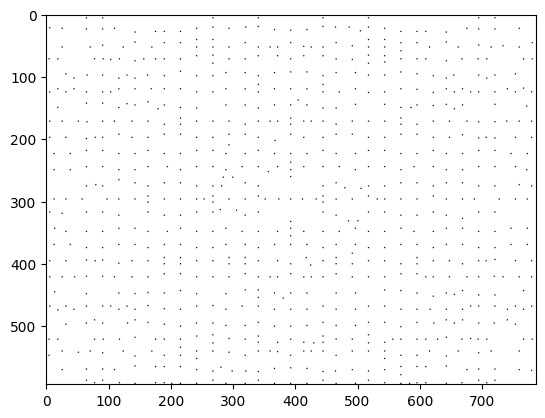

In [369]:
plt.imshow(mask[:,:,0], cmap = 'gray')

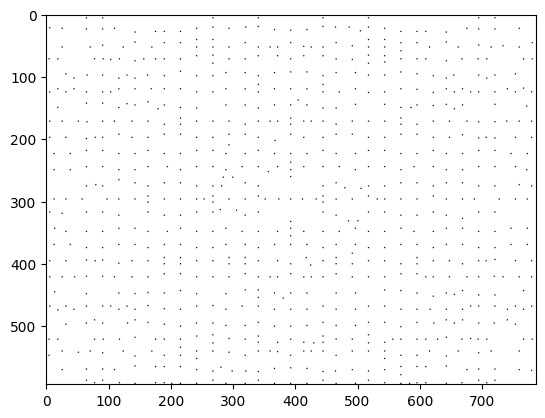

In [370]:
plt.imshow(mask[:,:,1], cmap = 'gray')

In [371]:
fft_image_real = cp.real(fft_image_shifted)
fft_image_imag = cp.imag(fft_image_shifted)

# Маскируем реальную и мнимую части
fft_image_real *= cp.array(mask[:, :, 0])
fft_image_imag *= cp.array(mask[:, :, 1])

# Собираем обратно комплексное число
filtered_fft = fft_image_real + 1j * fft_image_imag
# Обратное преобразование Фурье
filtered_image = cp.fft.ifftshift(filtered_fft)
filtered_image = cp.fft.ifft2(filtered_image).real
# Перенос результата обратно в CPU
result = cp.asnumpy(filtered_image)


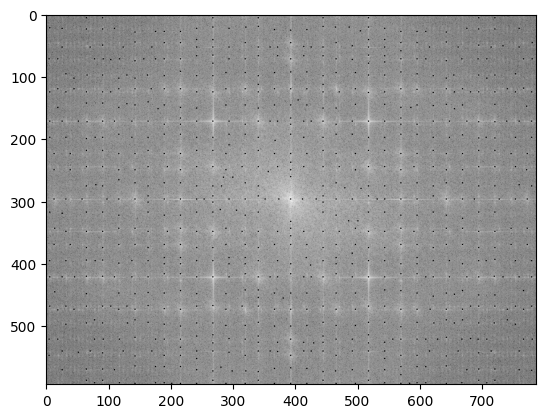

In [372]:
magn_spectrum = cp.abs(filtered_fft)
log_spectr = 20*np.log(magn_spectrum + 1)
log_spectr = log_spectr.get()
plt.imshow(log_spectr, cmap = 'gray')

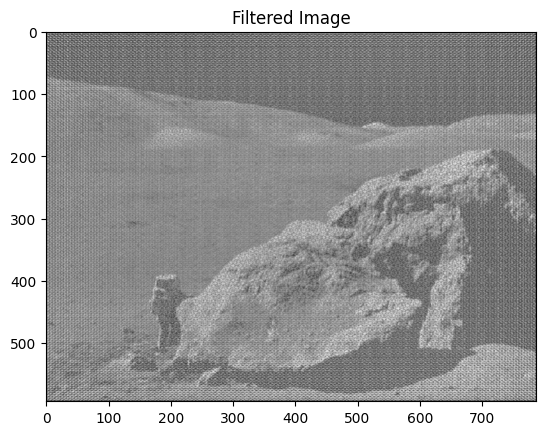

True

In [373]:
result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX)

# Отображаем отфильтрованное изображение
plt.imshow(result, cmap="gray")
plt.title("Filtered Image")
plt.show()  # Важно для отображения изображения в Jupyter
cv2.imwrite('./example/filtered_image.jpg', result.astype(np.uint8))
# Сохраняем результат
